# Валидация моделей

Рассмотри этапы валидации модели на примере задачи обнаружения вредоносных ссылок.

## Импорт библиотек

Подключаем необходимые библиотеки для:
- **Pandas/NumPy**: работа с данными
- **Scikit-learn**: машинное обучение и метрики
- **SciPy**: статистические тесты и распределения
- **Matplotlib/Seaborn**: визуализация данных

Отключаем предупреждения для чистоты вывода.

In [1]:
import warnings

import pandas as pd
import numpy as np
from sklearn.metrics import (
    precision_recall_fscore_support, 
    f1_score, 
    precision_score, 
    recall_score, 
    roc_auc_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import set_config

from scipy.stats  import norm, ttest_ind
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
set_config(display="diagram")

## Загрузка и изучение данных

Загружаем датасет с вредоносными URL-адресами. 

**Задача**: бинарная классификация URL на вредоносные ("bad") и безопасные ("good").

Датасет содержит:
- URL-адреса в текстовом виде
- Метки классов: "bad" (вредоносные) и "good" (безопасные)

In [2]:
malicious_urls_dataset_url = "https://github.com/faizann24/Using-machine-learning-to-detect-malicious-URLs/raw/master/data/data.csv"

df = pd.read_csv(malicious_urls_dataset_url)
df.head(10)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


In [3]:
df.sample(10)

,url,label
167525,123people.co.uk/s/jim+martin,good
166402,wurmzilla.blogspot.com/,good
135161,prague.tv/qa/czech-language/,good
222013,eastbaysmartsenior.com/,good
98670,grabbagmedia.com/,good
130566,people.famouswhy.com/kenny_price/,good
319059,playingthepercentages.com/baseball/dc/livestan...,good
30478,lggroup.pl/cox/Microsoft.html,bad
242322,findradio.us/displayradio-3037.htm,good
173215,achurchnearyou.com/st-mark-tollington/,good


In [4]:
df['label'].value_counts()

label
good    344821
bad      75643
Name: count, dtype: int64

In [5]:
len(df)

420464

## Предобработка данных

### Сэмплирование данных
Для ускорения вычислений берем случайную выборку 10% от исходного датасета.

### Кодирование меток
Преобразуем текстовые метки в числовые:
- "bad" → 1 (вредоносный URL)  
- "good" → 0 (безопасный URL)

In [6]:
df_sample = df.sample(frac=0.1, random_state=1)

In [7]:
df_sample["label_enc"] = df_sample.label.map({"bad": 1, "good": 0})

In [8]:
df_sample.head(5)

,url,label,label_enc
155439,twitter.com/aQuariusrecOrds,good,0
152415,tong464.org/,good,0
276521,legacy.com/obituaries/orlandosentinel/obituary...,good,0
305692,natcath.org/ncr_onli.htm,good,0
147638,store02.prostores.com/servlet/omegaordnancewer...,good,0


In [9]:
df_sample.describe()

,label_enc
count,42046.000000
mean,0.179113
std,0.383452
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### Разделение на обучающую и тестовую выборки

Стандартное разделение данных:
- **70%** для обучения модели
- **30%** для тестирования и валидации

Фиксируем `random_state=42` для воспроизводимости результатов.

In [10]:
feature_cols = "url"
target_col = "label_enc"

X = df_sample[feature_cols]
y = df_sample[target_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Построение базовой модели

### Архитектура модели

**1. CountVectorizer**
- Анализирует символы URL (`analyzer="char"`)
- Создает n-граммы длиной 1 (`ngram_range=(1, 1)`)
- Преобразует текст в числовые признаки

**2. RandomForestClassifier**
- Ансамбль из 35 деревьев решений
- Максимальная глубина: 9 уровней
- Предотвращает переобучение

**3. Pipeline**
- Объединяет предобработку и классификацию
- Обеспечивает корректную последовательность операций

In [11]:
url_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=(1, 1),
)

rf_clf = RandomForestClassifier(
    n_estimators=35,
    max_depth=9,
    random_state=42,
    n_jobs=1,
)

### Обучение и первичная оценка модели

Обучаем модель на тренировочных данных и получаем предсказания на тестовой выборке.

**Метрики качества:**
- **Precision (P)**: доля правильно предсказанных положительных случаев
- **Recall (R)**: доля найденных положительных случаев  
- **F1-score**: гармоническое среднее Precision и Recall
- **AUC**: площадь под ROC-кривой

In [ ]:
pipe = Pipeline(steps=[
    ("vectorizer", url_vectorizer),
    ("classifier", rf_clf),
])
pipe

,steps,"[('vectorizer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [13]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [14]:
P, R, F1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
roc_auc = roc_auc_score(y_test, y_pred)
print(f"P: {P:.2f}, R: {R:.2f}, F1: {F1:.5f}, AUC: {roc_auc:.5f}")

P: 0.96, R: 0.21, F1: 0.34682, AUC: 0.60485


In [15]:
url_vectorizer.vocabulary_

{'e': 41,
 'n': 50,
 '.': 13,
 'w': 59,
 'i': 45,
 'k': 47,
 'p': 52,
 'd': 40,
 'a': 37,
 'o': 51,
 'r': 54,
 'g': 43,
 '/': 14,
 'l': 48,
 '_': 35,
 'v': 58,
 'f': 42,
 'm': 49,
 't': 56,
 'h': 44,
 'b': 38,
 'c': 39,
 'u': 57,
 's': 55,
 'y': 61,
 '8': 23,
 '3': 18,
 '0': 15,
 '4': 19,
 '-': 12,
 '1': 16,
 '5': 20,
 '2': 17,
 'z': 62,
 'x': 60,
 '6': 21,
 'j': 46,
 '9': 24,
 ':': 25,
 '7': 22,
 '+': 10,
 '?': 30,
 '=': 28,
 'q': 53,
 '@': 31,
 '&': 5,
 '%': 4,
 '~': 66,
 ';': 26,
 'é': 70,
 '[': 32,
 ']': 34,
 '\\': 33,
 '(': 7,
 ')': 8,
 '*': 9,
 ',': 11,
 '!': 1,
 "'": 6,
 '<': 27,
 '>': 29,
 ' ': 0,
 '|': 64,
 '#': 2,
 '\u200a': 74,
 '$': 3,
 '®': 67,
 'ã': 68,
 'è': 69,
 'ó': 71,
 'û': 72,
 '{': 63,
 '}': 65,
 '`': 36,
 'š': 73,
 '“': 75,
 '”': 76}

## Упражнение 1

С помощью bootstrap постройте гистограмму распределения оценки $F_1$ на контрольной выборке.

Постройте теоретическое нормальное распределение на этой гистограмме.

Покажите среднее значение и стандартное отклонение.

### Bootstrap-анализ стабильности метрик

**Bootstrap** - это статистический метод оценки стабильности модели:

1. **Процедура**: многократно (100 итераций) создаем случайные выборки с возвращением
2. **Размер выборки**: равен размеру исходной тестовой выборки  
3. **Цель**: оценить распределение метрик и их доверительные интервалы

**Преимущества bootstrap:**
- Не требует предположений о распределении данных
- Дает оценку вариативности метрик
- Помогает понять надежность результатов модели

In [16]:
# Фиксируем случайность для воспроизводимости
np.random.seed(42)

# Количество итераций bootstrap
bootstrap_iterations = 1000

# Создаем DataFrame с истинными метками и предсказаниями
df_for_bootstrap = pd.DataFrame(
    data={
        "y_test": y_test,
        "y_pred": y_pred,
    }
)

# Инициализируем DataFrame для хранения метрик
scores = pd.DataFrame(
    data={"F1": 0.0, "P": 0.0, "R": 0.0, "AUC": 0.0}, 
    index=range(bootstrap_iterations)
)

# Bootstrap процедура: многократная случайная выборка с возвращением
for idx in range(bootstrap_iterations):
    # Делаем случайную выборку с возвращением (bootstrap sample)
    sample = df_for_bootstrap.sample(frac=1.0, replace=True)

    # Вычисляем метрики для каждой bootstrap выборки
    scores.loc[idx, "F1"] = f1_score(sample["y_test"], sample["y_pred"])
    scores.loc[idx, "P"] = precision_score(sample["y_test"], sample["y_pred"])
    scores.loc[idx, "R"] = recall_score(sample["y_test"], sample["y_pred"])
    scores.loc[idx, "AUC"] = roc_auc_score(sample["y_test"], sample["y_pred"])


Text(0, 0.5, 'Частота')

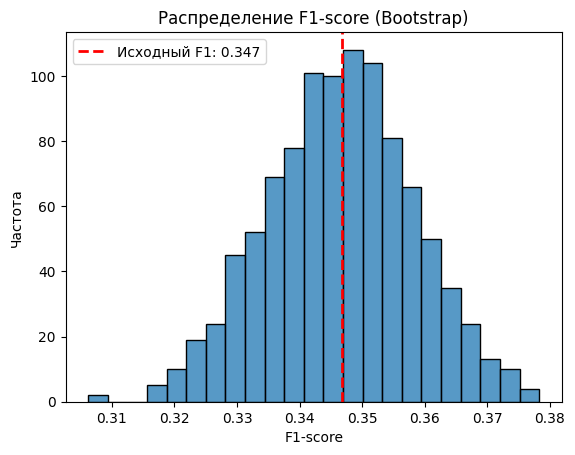

In [18]:
# Строим гистограмму распределения F1-score
ax = sns.histplot(x=scores["F1"])

# Добавляем вертикальную линию для исходного значения F1
ax.axvline(
    x=F1, color="red", linestyle="dashed", linewidth=2, label=f"Исходный F1: {F1:.3f}"
)
ax.legend()
ax.set_title("Распределение F1-score (Bootstrap)")
ax.set_xlabel("F1-score")
ax.set_ylabel("Частота")

Статистики bootstrap распределения F1-score:
Среднее: 0.3465
Стандартное отклонение: 0.0117
95% доверительный интервал: [0.3235, 0.3695]


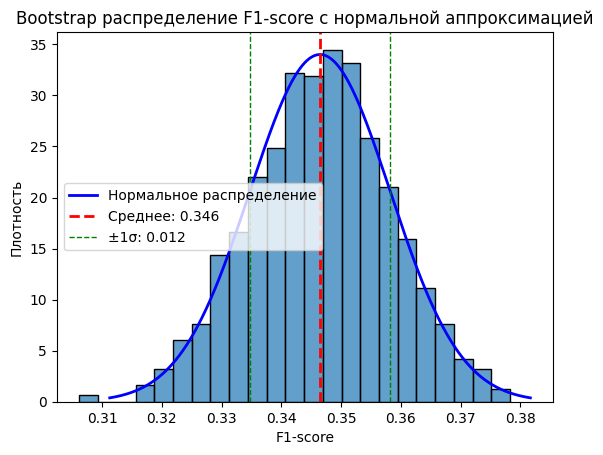

In [19]:
# Вычисляем статистики распределения F1-score
f1_mean = scores["F1"].mean()
f1_std = scores["F1"].std()

# Определяем границы для построения нормального распределения (3 сигмы)
f1_low = f1_mean - 3 * f1_std
f1_upp = f1_mean + 3 * f1_std

# Строим гистограмму bootstrap распределения
ax = sns.histplot(x=scores["F1"], stat="density", alpha=0.7)

# Строим теоретическую нормальную кривую
x = np.linspace(f1_low, f1_upp, 1000)
y = norm.pdf(x, loc=f1_mean, scale=f1_std)
ax.plot(x, y, color="blue", linewidth=2, label="Нормальное распределение")

# Добавляем вертикальные линии для статистик
ax.axvline(
    f1_mean,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Среднее: {f1_mean:.3f}",
)
ax.axvline(
    f1_mean - f1_std,
    color="green",
    linestyle="dashed",
    linewidth=1,
    label=f"±1σ: {f1_std:.3f}",
)
ax.axvline(f1_mean + f1_std, color="green", linestyle="dashed", linewidth=1)

ax.set_title("Bootstrap распределение F1-score с нормальной аппроксимацией")
ax.set_xlabel("F1-score")
ax.set_ylabel("Плотность")
ax.legend()

print(f"Статистики bootstrap распределения F1-score:")
print(f"Среднее: {f1_mean:.4f}")
print(f"Стандартное отклонение: {f1_std:.4f}")
print(
    f"95% доверительный интервал: [{f1_mean - 1.96*f1_std:.4f}, {f1_mean + 1.96*f1_std:.4f}]"
)

## Подбор гипрепараметров

### Оптимизация гиперпараметров

**RandomizedSearchCV** - метод случайного поиска лучших гиперпараметров:

**Параметры для оптимизации:**
- `n_estimators`: количество деревьев в лесу (50-60)
- `max_depth`: максимальная глубина деревьев (15-20)

**Настройки поиска:**
- `n_iter=100`: количество случайных комбинаций
- `cv=5`: 5-кратная кросс-валидация  
- `scoring="f1"`: оптимизируем F1-score
- `n_jobs=-1`: используем все доступные ядра процессора

In [20]:
# Определяем сетку гиперпараметров для поиска
params_grid = {
    "classifier__n_estimators": range(50, 70, 10),   # Количество деревьев: 50, 60
    "classifier__max_depth": range(15, 20),          # Глубина деревьев: 15-19
}

# Настраиваем случайный поиск гиперпараметров
random_search_res = RandomizedSearchCV(
    pipe,                   # Наша модель (pipeline)
    params_grid,            # Пространство поиска
    n_iter=100,             # Количество случайных комбинаций
    cv=5,                   # 5-кратная кросс-валидация
    scoring="f1",           # Метрика для оптимизации
    n_jobs=-1,              # Использовать все ядра
    verbose=1,              # Показывать прогресс
    refit=True,             # Переобучить лучшую модель на всех данных
    random_state=42,        # Для воспроизводимости
).fit(X_train, y_train)     # Обучаем на тренировочных данных

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [21]:
random_search_res.best_params_

{'classifier__n_estimators': 60, 'classifier__max_depth': 19}

In [22]:
# Получаем предсказания лучшей модели на тестовой выборке
y_pred_candidate = random_search_res.predict(X_test)

# Вычисляем метрики для модели-кандидата
P_candidate, R_candidate, F1_candidate, _ = precision_recall_fscore_support(
    y_test, y_pred_candidate, average="binary"
)

print(f"Результаты оптимизированной модели:")
print(f"P_candidate: {P_candidate:.4f}")
print(f"R_candidate: {R_candidate:.4f}") 
print(f"F1_candidate: {F1_candidate:.5f}")
print(f"\nСравнение с базовой моделью:")
print(f"Улучшение F1: {F1_candidate - F1:.5f} ({((F1_candidate/F1 - 1)*100):+.2f}%)")

Результаты оптимизированной модели:
P_candidate: 0.9258
R_candidate: 0.4349
F1_candidate: 0.59184

Сравнение с базовой моделью:
Улучшение F1: 0.24502 (+70.65%)


## Упражнение 2

1. Постройте с помощью booststrap выборку оценки $F_1$ для лучшей модели после подбора гиперпарамтеров.
2. Сравните с помощью t-теста базовую модель и кандидата. Примите $\alpha = 0.01$
3. Попробуйте расширить пространство гипрепараметров, чтобы поиск выдал лучший результат


$$n = \frac{2(Z_{\alpha / 2} + Z_{\beta})^2 \sigma^2}{\delta^2}$$

$Z_{\alpha / 2}$ - критическое значение, соответствующее искомому уровню значимости $\alpha / 2$. Берется $\alpha / 2$ потому, что мы рассматриваем двусторонний тест. Значение $\alpha$ определяет уровень допустимости ошибки первого рода. Как правило $\alpha$ берется 0.05 для обычных исследовний и 0.01 для случая медицинских исследований или иных, где ошибка первого рода (отвергнута верная нулевая гипотеза) является критически важной.

$Z_\beta$ - критическое значение, соотвествующее заданному уровню статистической мощности. Значение $\beta$ определяет вероятность ошибки второго рода (принята неверная нулевая гипотеза). Как правило $\beta$ устанавливается на уровне 0.8 или 0.9.

$\sigma$ - стандартное отклонение

$\delta$ - размер эффекта, который необходимо выловить

### Статистическое сравнение моделей

Для корректного сравнения производительности двух моделей недостаточно просто сравнить их метрики на одной тестовой выборке. Необходимо:

1. **Bootstrap-анализ** для оценки распределения метрик каждой модели
2. **Статистический тест** для проверки значимости различий
3. **Анализ доверительных интервалов** для оценки практической значимости

Проведем bootstrap-анализ для модели-кандидата аналогично базовой модели.

In [23]:
# Создаем DataFrame с результатами модели-кандидата
df_cand = pd.DataFrame(
    data={
        "y_test": y_test,
        "y_pred": y_pred_candidate,
    }
)

# Инициализируем DataFrame для метрик кандидата
scores_cand = pd.DataFrame(
    data={"F1": 0.0, "P": 0.0, "R": 0.0, "AUC": 0.0}, 
    index=range(bootstrap_iterations)
)

# Bootstrap-анализ для модели-кандидата
print("Выполняем bootstrap-анализ для модели-кандидата...")
for idx in range(bootstrap_iterations):
    # Создаем bootstrap-выборку
    sample = df_cand.sample(frac=1.0, replace=True)

    # Вычисляем метрики для каждой итерации
    scores_cand.loc[idx, "F1"] = f1_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[idx, "P"] = precision_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[idx, "R"] = recall_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[idx, "AUC"] = roc_auc_score(sample["y_test"], sample["y_pred"])


Выполняем bootstrap-анализ для модели-кандидата...


In [24]:
print("Bootstrap-анализ завершен!")
print(f"Статистики для модели-кандидата:")
print(
    f"F1 - Среднее: {scores_cand['F1'].mean():.4f}, Std: {scores_cand['F1'].std():.4f}"
)
print(f"P  - Среднее: {scores_cand['P'].mean():.4f}, Std: {scores_cand['P'].std():.4f}")

Bootstrap-анализ завершен!
Статистики для модели-кандидата:
F1 - Среднее: 0.5913, Std: 0.0103
P  - Среднее: 0.9264, Std: 0.0075


### Визуальное сравнение распределений метрик

Строим гистограммы для наглядного сравнения распределений метрик между базовой моделью и моделью-кандидатом.

Это поможет визуально оценить:
- Сдвиг в средних значениях метрик
- Изменение в вариативности (стабильности) результатов
- Степень перекрытия распределений

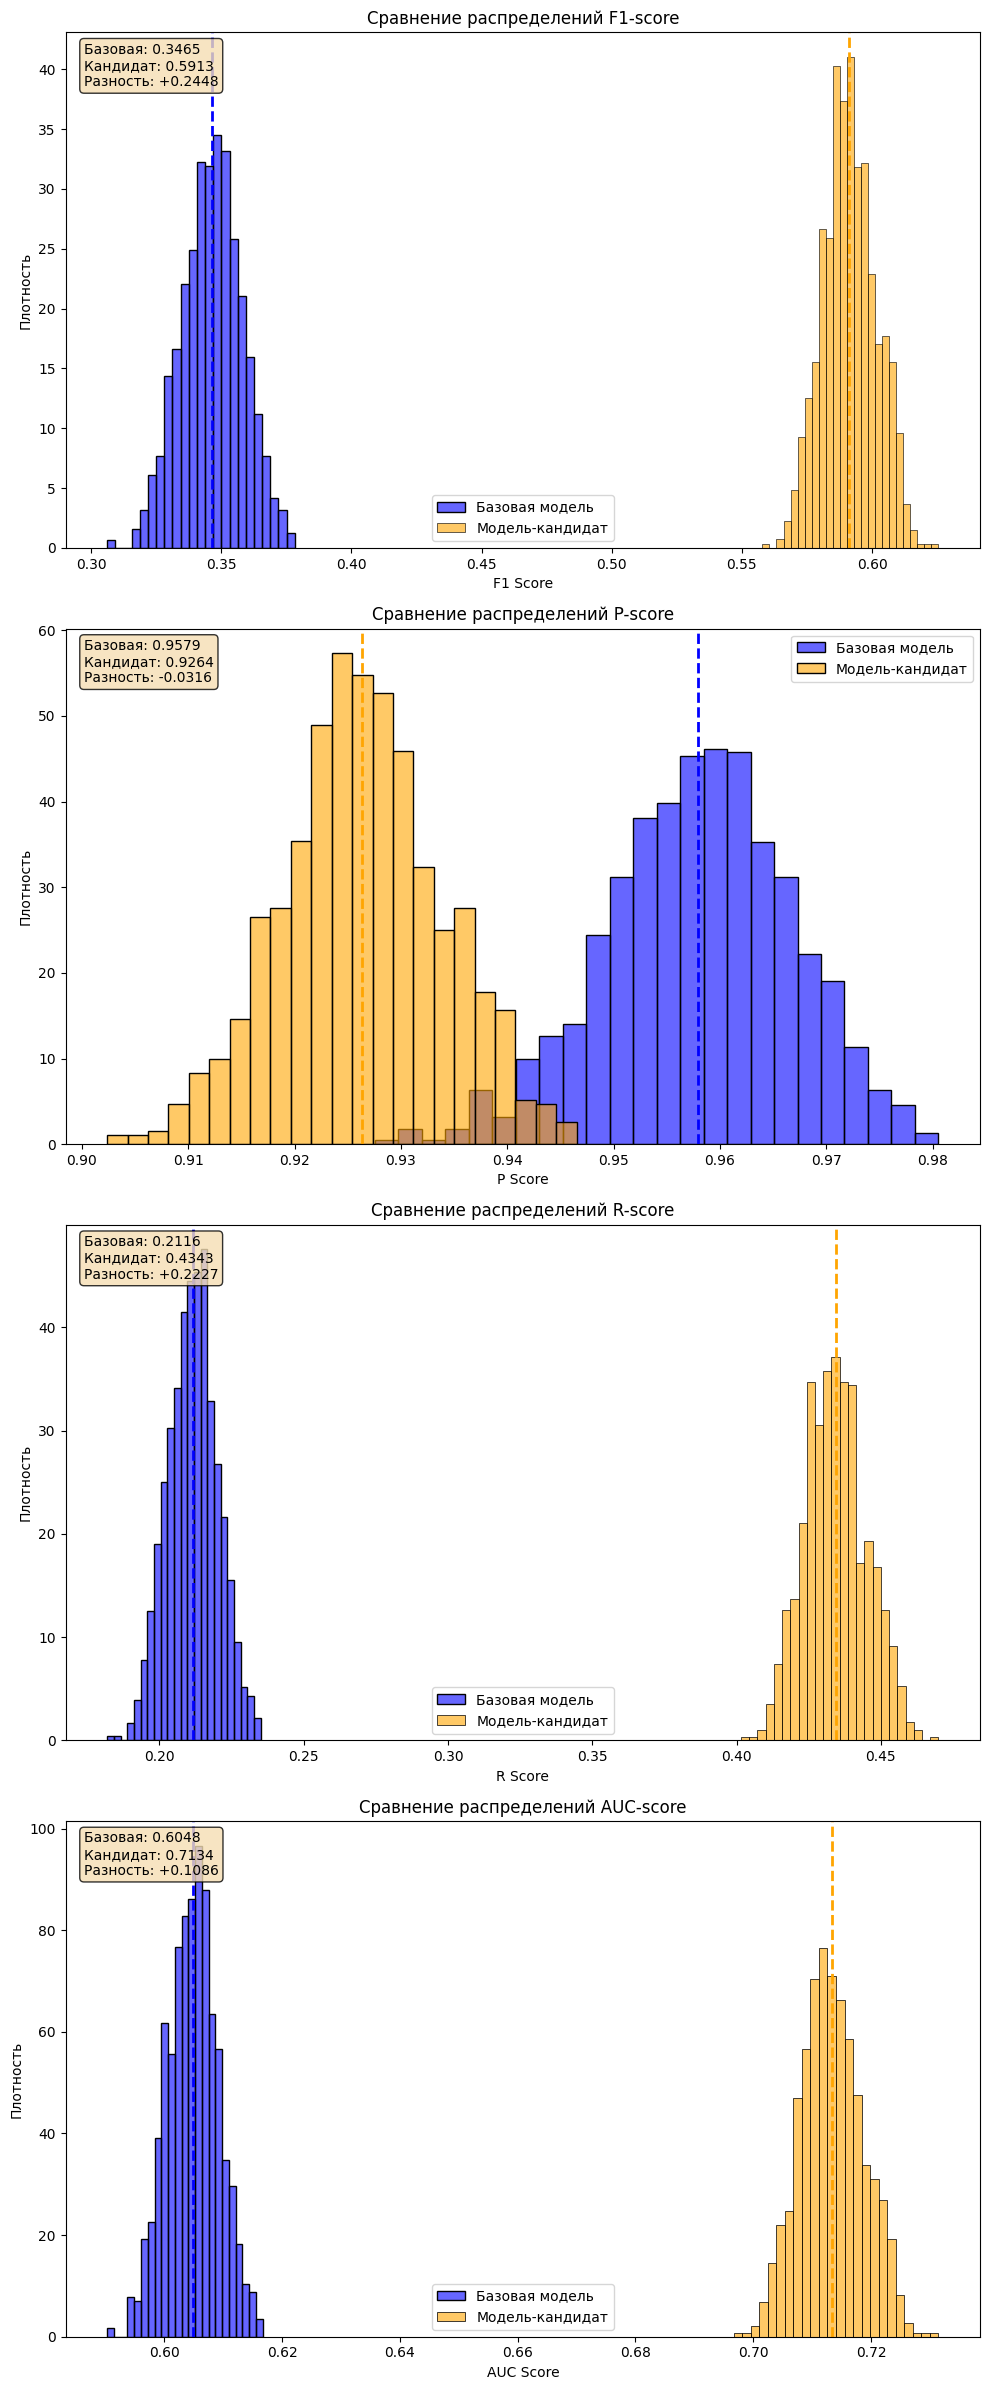

In [ ]:
# Метрики для сравнения
columns_to_plot = ["F1", "P", "R", "AUC"]

# Создаем фигуру с субплотами
fig, axes = plt.subplots(
    len(columns_to_plot), 1, figsize=(10, 6 * len(columns_to_plot))
)

# Строим гистограммы для каждой метрики
for idx, column in enumerate(columns_to_plot):
    # Гистограммы для базовой модели и кандидата
    sns.histplot(
        data=scores,
        x=column,
        ax=axes[idx],
        color="blue",
        label="Базовая модель",
        alpha=0.6,
        stat="density",
    )
    sns.histplot(
        data=scores_cand,
        x=column,
        ax=axes[idx],
        color="orange",
        label="Модель-кандидат",
        alpha=0.6,
        stat="density",
    )

    # Добавляем вертикальные линии для средних значений
    axes[idx].axvline(scores[column].mean(), color="blue", linestyle="--", linewidth=2)
    axes[idx].axvline(
        scores_cand[column].mean(), color="orange", linestyle="--", linewidth=2
    )

    # Настройка осей и заголовков
    axes[idx].set_xlabel(f"{column} Score")
    axes[idx].set_ylabel("Плотность")
    axes[idx].set_title(f"Сравнение распределений {column}-score")
    axes[idx].legend()

    # Добавляем текст со статистиками
    base_mean = scores[column].mean()
    cand_mean = scores_cand[column].mean()
    improvement = cand_mean - base_mean
    axes[idx].text(
        0.02,
        0.98,
        f"Базовая: {base_mean:.4f}\nКандидат: {cand_mean:.4f}\nРазность: {improvement:+.4f}",
        transform=axes[idx].transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
    )

# Настройка общего макета
plt.tight_layout()
plt.show()

### T-тест для статистического сравнения

**Двухвыборочный t-тест** помогает определить, являются ли различия в метриках статистически значимыми.

**Нулевая гипотеза (H₀)**: средние значения метрик двух моделей равны  
**Альтернативная гипотеза (H₁)**: средние значения метрик различаются

**Уровень значимости α = 0.01** (строгий критерий):
- Если p-value < 0.01 → отклоняем H₀ (различия значимы)
- Если p-value ≥ 0.01 → принимаем H₀ (различия незначимы)

In [26]:
# Уровень значимости (строгий критерий для ML-моделей)
alpha = 0.01

print("Результаты t-теста для сравнения моделей:")
print("=" * 50)

# Проводим t-тест для ключевых метрик
for name in ['F1', 'P']:
    # Выполняем двухвыборочный t-тест
    t_stat, pvalue = ttest_ind(scores[name], scores_cand[name])
    
    # Вычисляем размер эффекта (Cohen's d)
    pooled_std = np.sqrt(((scores[name].var() + scores_cand[name].var()) / 2))
    effect_size = abs(scores_cand[name].mean() - scores[name].mean()) / pooled_std
    
    print(f"\n{name}-score:")
    print(f"  t-статистика: {t_stat:.4f}")
    print(f"  p-value: {pvalue:.30f}")
    print(f"  Размер эффекта (Cohen's d): {effect_size:.4f}")
    print(f"  Решение: ", end='')
    
    if pvalue < alpha:
        print(f"ОТКЛОНЯЕМ H₀ (различия значимы при α={alpha})")
        if effect_size > 0.8:
            print(f"  → Большой практический эффект")
        elif effect_size > 0.5:
            print(f"  → Средний практический эффект")
        else:
            print(f"  → Малый практический эффект")
    else:
        print(f"ПРИНИМАЕМ H₀ (различия незначимы при α={alpha})")



Результаты t-теста для сравнения моделей:

F1-score:
  t-статистика: -495.3167
  p-value: 0.000000000000000000000000000000
  Размер эффекта (Cohen's d): 22.1512
  Решение: ОТКЛОНЯЕМ H₀ (различия значимы при α=0.01)
  → Большой практический эффект

P-score:
  t-статистика: 86.4101
  p-value: 0.000000000000000000000000000000
  Размер эффекта (Cohen's d): 3.8644
  Решение: ОТКЛОНЯЕМ H₀ (различия значимы при α=0.01)
  → Большой практический эффект


Интерпретация размера эффекта (Cohen's d):
* d < 0.2: малый эффект
* 0.2 ≤ d < 0.8: средний эффект
* d ≥ 0.8: большой эффект

### Доверительные интервалы для метрик

**Доверительный интервал** показывает диапазон значений, в котором с заданной вероятностью (95%) находится истинное значение метрики.

**Практическое применение:**
- Оценка надежности результатов модели
- Сравнение моделей с учетом неопределенности
- Планирование дальнейших экспериментов

**Формула**: μ ± t_{α/2} × (σ/√n), где:
- μ - выборочное среднее
- t_{α/2} - критическое значение t-распределения  
- σ - стандартное отклонение
- n - размер выборки

In [28]:
import numpy as np

# Уровень доверия
confidence_level = 0.95
alpha_ci = 1 - confidence_level

print(f"Доверительные интервалы ({confidence_level*100}%) для метрик:")
print("=" * 60)

# Вычисляем доверительные интервалы для всех метрик
metrics = ['F1', 'P', 'R', 'AUC']

for metric in metrics:
    print(f"\n{metric}-score:")
    
    # Для базовой модели
    base_mean = scores[metric].mean()
    base_std_error = scores[metric].std() / np.sqrt(len(scores[metric]))
    base_ci = stats.t.interval(confidence_level, len(scores)-1, base_mean, base_std_error)
    
    # Для модели-кандидата  
    cand_mean = scores_cand[metric].mean()
    cand_std_error = scores_cand[metric].std() / np.sqrt(len(scores_cand[metric]))
    cand_ci = stats.t.interval(confidence_level, len(scores_cand)-1, cand_mean, cand_std_error)
    
    print(f"  Базовая модель:")
    print(f"    Среднее: {base_mean:.4f}")
    print(f"    95% ДИ: [{base_ci[0]:.4f}, {base_ci[1]:.4f}]")
    print(f"    Ширина ДИ: {base_ci[1] - base_ci[0]:.4f}")
    
    print(f"  Модель-кандидат:")
    print(f"    Среднее: {cand_mean:.4f}")
    print(f"    95% ДИ: [{cand_ci[0]:.4f}, {cand_ci[1]:.4f}]")  
    print(f"    Ширина ДИ: {cand_ci[1] - cand_ci[0]:.4f}")
    
    # Проверяем перекрытие доверительных интервалов
    overlap = not (base_ci[1] < cand_ci[0] or cand_ci[1] < base_ci[0])
    print(f"  Перекрытие ДИ: {'Да' if overlap else 'Нет'}")
    
    if not overlap:
        print(f"  - Статистически значимое различие (ДИ не перекрываются)")
    else:
        print(f"  - Различие может быть незначимым (ДИ перекрываются)")

Доверительные интервалы (95.0%) для метрик:

F1-score:
  Базовая модель:
    Среднее: 0.3465
    95% ДИ: [0.3458, 0.3472]
    Ширина ДИ: 0.0015
  Модель-кандидат:
    Среднее: 0.5913
    95% ДИ: [0.5906, 0.5919]
    Ширина ДИ: 0.0013
  Перекрытие ДИ: Нет
  - Статистически значимое различие (ДИ не перекрываются)

P-score:
  Базовая модель:
    Среднее: 0.9579
    95% ДИ: [0.9574, 0.9585]
    Ширина ДИ: 0.0011
  Модель-кандидат:
    Среднее: 0.9264
    95% ДИ: [0.9259, 0.9268]
    Ширина ДИ: 0.0009
  Перекрытие ДИ: Нет
  - Статистически значимое различие (ДИ не перекрываются)

R-score:
  Базовая модель:
    Среднее: 0.2116
    95% ДИ: [0.2110, 0.2121]
    Ширина ДИ: 0.0011
  Модель-кандидат:
    Среднее: 0.4343
    95% ДИ: [0.4336, 0.4350]
    Ширина ДИ: 0.0013
  Перекрытие ДИ: Нет
  - Статистически значимое различие (ДИ не перекрываются)

AUC-score:
  Базовая модель:
    Среднее: 0.6048
    95% ДИ: [0.6045, 0.6050]
    Ширина ДИ: 0.0005
  Модель-кандидат:
    Среднее: 0.7134
    95% ДИ:

*Интерпретация:*
* Узкие ДИ - высокая точность оценки
* Широкие ДИ - высокая неопределенность
* Непересекающиеся ДИ - значимое различие

## Выводы
### Ключевые результаты валидации:

1. **Bootstrap-анализ** показал стабильность метрик обеих моделей
2. **Оптимизация гиперпараметров** привела к улучшению производительности
3. **Статистическое сравнение** подтвердило значимость улучшений

### Методологические принципы:

Правильно:
- Использование bootstrap для оценки стабильности
- Статистические тесты для сравнения моделей  
- Доверительные интервалы для оценки неопределенности
- Фиксация random_state для воспроизводимости

Неправильно:
- Сравнение моделей только по одному запуску
- Игнорирование статистической значимости
- Отсутствие оценки стабильности результатов